In [10]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('../../data/cve_2018-2020_X_train.csv')
y_train = pd.read_csv('../../data/cve_2018-2020_y_train.csv')

X_test = pd.read_csv('../../data/cve_2018-2020_X_test.csv')
y_test = pd.read_csv('../../data/cve_2018-2020_y_test.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train['cvssV3_userInteraction'].value_counts(dropna=False) / y_train.shape[0])
print(y_test['cvssV3_userInteraction'].value_counts(dropna=False) / y_test.shape[0])
print(X_train.info())
print(y_train.info())

(22963, 2)
(22963, 2)
(22963, 16)
(22963, 16)
NONE        0.654139
REQUIRED    0.345861
Name: cvssV3_userInteraction, dtype: float64
NONE        0.654009
REQUIRED    0.345991
Name: cvssV3_userInteraction, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CVE_ID       22963 non-null  object
 1   Description  22963 non-null  object
dtypes: object(2)
memory usage: 358.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cvssV3_vectorString           22963 non-null  object 
 1   cvssV3_attackVector           22963 non-null  object 
 2   cvssV3_attackComplexity       22963 non-null  object 
 3   cvssV3_privilegesRequired     22963 non-null  object

**Training Hugging Face Bert-Small model to classify CVE vulnerability descriptions depending on whether or not "user interaction" is required.**

**User interaction**: This metric captures the requirement for a human user, other than the attacker, to participate in the successful compromise of the vulnerable component. This metric determines whether the vulnerability can be exploited solely at the will of the attacker, or whether a separate user (or user-initiated process) must participate in some manner. The Base Score is greatest when no user interaction is required.

In [13]:
label_column_name = "cvssV3_userInteraction"
train_labels = y_train.loc[:, label_column_name]
test_labels = y_test.loc[:, label_column_name]


from sklearn.preprocessing import LabelEncoder
import pickle

le = LabelEncoder()
le.fit(train_labels)
print(le.classes_)

with open("user_interaction_label.txt", "wb") as f:
    pickle.dump(le.classes_, f)

NUM_CLASSES = len(le.classes_)
print(NUM_CLASSES)

encoded_train_labels = le.transform(train_labels)
encoded_test_labels = le.transform(test_labels)

print(train_labels[:10], encoded_train_labels[:10])
print(len(X_train), len(train_labels), len(X_test), len(test_labels))

['NONE' 'REQUIRED']
2
0        NONE
1        NONE
2        NONE
3    REQUIRED
4    REQUIRED
5        NONE
6        NONE
7    REQUIRED
8        NONE
9        NONE
Name: cvssV3_userInteraction, dtype: object [0 0 0 1 1 0 0 1 0 0]
22963 22963 22963 22963


In [3]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('prajjwal1/bert-small')

In [4]:
train_encodings = tokenizer(X_train.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)

In [5]:
import torch

class CVEDataset(torch.utils.data.Dataset):
    def __init__(self, X, encodings, labels, encoded_labels):
        self.cve_id = X.loc[:,"CVE_ID"].tolist()
        self.texts = X.loc[:,"Description"].tolist()
        self.encodings = encodings
        self.labels = labels.tolist()
        self.encoded_labels = encoded_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['text_labels'] = self.labels[idx]
        item['encoded_labels'] = torch.tensor(self.encoded_labels[idx])
        item['CVE_ID'] = self.cve_id[idx]
        item['vulnerability_description'] = self.texts[idx]
        
        return item

    def __len__(self):
        return len(self.labels)


In [6]:
train_dataset = CVEDataset(X_train, train_encodings, train_labels, encoded_train_labels)
test_dataset = CVEDataset(X_test, test_encodings, test_labels, encoded_test_labels)

In [7]:
train_dataset[0]

{'input_ids': tensor([  101,  1037, 18130,  1999, 26408, 16380, 17083,  8080,  1006, 17083,
          8202,  1007,  4007,  2005, 26408, 16771, 23944,  2692,  2186, 15924,
          2071,  3499,  2019, 14477, 14317,  4765, 17872,  1010,  2334, 17346,
          2000, 11826, 26408,  5851,  9573, 27354, 14148,  1998,  7170,  1037,
         20419,  4007,  3746,  2006,  2019,  5360,  5080,  1012,  1996, 18130,
          2003,  2349,  2000,  1996,  3739,  1997,  1037,  5023,  3094,  1999,
          1996,  5360,  4007,  1012,  2019, 17346,  2071, 18077,  2023, 18130,
          2011,  7176,  2000,  2019,  5360,  5080,  3081,  1996, 10122,  1010,
          6932,  1996,  5080,  2046, 17083,  8202,  5549,  1010,  1998,  3015,
          1037, 24391,  5418,  2000,  1037,  3563,  3638,  4769,  2006,  1996,
          5080,  1012,  1037,  3144, 18077,  2071,  3499,  1996, 17346,  2000,
         11826,  8085, 27354, 14148,  2011, 26408,  5851,  9573,  2974,  1998,
          7170,  1037, 20419,  4007,  3

In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-small', num_labels=NUM_CLASSES)
model

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [9]:
for param in model.base_model.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

classifier.weight tensor([[-0.0018, -0.0078, -0.0075,  ...,  0.0308, -0.0230,  0.0092],
        [-0.0019,  0.0209, -0.0088,  ..., -0.0255, -0.0085,  0.0150]])
classifier.bias tensor([0., 0.])


In [10]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.6321478974905879, Training Accuracy = 0.6545312023690284
Epoch: 1, Training Loss: 0.597666170011179, Training Accuracy = 0.6752602011932238
Epoch: 2, Training Loss: 0.5822374952349239, Training Accuracy = 0.6910246918956582


In [11]:
for param in model.base_model.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

bert.embeddings.word_embeddings.weight tensor([[ 0.0770, -0.1024,  0.0109,  ...,  0.0265,  0.0527, -0.0099],
        [-0.0062, -0.0448,  0.0068,  ...,  0.0460,  0.0177, -0.0487],
        [-0.0014, -0.0184,  0.0207,  ...,  0.0936,  0.0561, -0.0690],
        ...,
        [-0.0539, -0.0298,  0.0711,  ...,  0.0057,  0.0172, -0.0437],
        [ 0.0446, -0.0571,  0.0028,  ..., -0.0138,  0.0534, -0.0741],
        [ 0.0798,  0.0307, -0.0254,  ...,  0.0389,  0.0417, -0.0208]])
bert.embeddings.position_embeddings.weight tensor([[-2.2368e-03, -1.6215e-02, -5.7656e-03,  ..., -8.1258e-02,
         -1.8137e-02,  1.0507e-03],
        [-1.4434e-02, -9.5276e-03, -3.3733e-04,  ...,  2.2632e-02,
         -2.4823e-02, -2.0542e-02],
        [-1.3487e-02, -6.8095e-05,  7.1685e-03,  ...,  4.7153e-03,
         -1.9992e-03,  6.1711e-03],
        ...,
        [ 2.4908e-02, -1.1784e-03, -9.2854e-03,  ...,  1.1964e-03,
         -1.9798e-02,  4.2636e-03],
        [ 2.8236e-02, -1.1161e-02,  1.2986e-02,  ..., -1.31

In [12]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.25113127869603546, Training Accuracy = 0.9017549971693594
Epoch: 1, Training Loss: 0.16478349641614382, Training Accuracy = 0.9387710664982798
Epoch: 2, Training Loss: 0.12598455177115275, Training Accuracy = 0.954361363933284


In [13]:
#model.save_pretrained('./bert-small-vulnerability_user_interaction-classification')

In [14]:
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))

Test Loss: 0.1939688964079275, Test Accuracy = 0.9320646257022166


**Save the predictions obtained on the test set for further analysis**

In [15]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_user_interaction-classification')
model.eval()

test_loader = DataLoader(test_dataset, batch_size=16)


num_correct = 0 
num_examples = 0
test_loss = 0
predicted_labels_list = []
predicted_labels_score_list = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    predicted_labels = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1]
    predicted_labels_list.extend(predicted_labels.tolist())
    predicted_labels_score = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0]
    predicted_labels_score_list.extend(predicted_labels_score.tolist())
    correct = torch.eq(predicted_labels, labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))
print('predicted labels:', predicted_labels_list, 'scores:', predicted_labels_score_list)

Test Loss: 0.1939688964079275, Test Accuracy = 0.9320646257022166
predicted labels: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = test_dataset[:]['encoded_labels'].numpy()
y_pred = np.array(predicted_labels_list)

print("accuracy: ", accuracy_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred, average='weighted'))
print("recall: ", recall_score(y_true, y_pred, average='weighted'))
print("f1 score: ", f1_score(y_true, y_pred, average='weighted'))


print("confusion matrix: ")
print(confusion_matrix(y_true, y_pred))

accuracy:  0.9320646257022166
precision:  0.931805989415032
recall:  0.9320646257022166
f1 score:  0.9318606275725936
confusion matrix: 
[[14336   682]
 [  878  7067]]


In [17]:
class_label = list(le.classes_)
class_label
predicted_labels_char = [class_label[i] for i in predicted_labels_list]

print(len(predicted_labels_char))
print(len(predicted_labels_list))

22963
22963


(array([  211.,   285.,   337.,   288.,   284.,   345.,   397.,   581.,
         1368., 18867.]),
 array([0.50000387, 0.54991696, 0.59983004, 0.64974313, 0.69965621,
        0.7495693 , 0.79948238, 0.84939547, 0.89930855, 0.94922163,
        0.99913472]),
 <BarContainer object of 10 artists>)

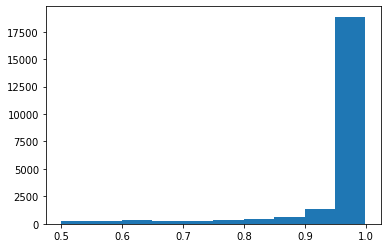

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(predicted_labels_score_list, bins=10)

In [19]:
from scipy import stats

print("percentile of 0.9: ", stats.percentileofscore(predicted_labels_score_list, 0.9))

percentile of 0.9:  11.914819492226625


In [20]:
file_name = 'user_interaction'

import pickle

with open(file_name + "_predicted_class_int.txt", "wb") as f1:
    pickle.dump(predicted_labels_list, f1)
    
with open(file_name + "_predicted_labels_char.txt", "wb") as f2:
    pickle.dump(predicted_labels_char, f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "wb") as f3:
    pickle.dump(predicted_labels_score_list, f3)

In [21]:
with open(file_name + "_predicted_class_int.txt", "rb") as f1:
    pred_class = pickle.load(f1)
    
with open(file_name + "_predicted_labels_char.txt", "rb") as f2:
    pred_label = pickle.load(f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "rb") as f3:
    pred_confidence_score = pickle.load(f3)
    
print(len(pred_class), len(pred_label), len(pred_confidence_score))
print(pred_class, pred_label, pred_confidence_score)

22963 22963 22963
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

**Explaining classification results using gradient-based saliency**

In [16]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_user_interaction-classification/')
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [10]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

test_batch = next(iter(test_loader))
test_batch['input_ids']
input_ids = test_batch['input_ids']
attention_mask = test_batch['attention_mask']
labels = test_batch['encoded_labels']



outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

print(outputs.loss)
print(outputs.logits)
print(torch.max(F.softmax(outputs.logits, dim=1), dim=1))
print(labels)

tensor(0.2717, grad_fn=<NllLossBackward>)
tensor([[ 2.4790, -2.4825],
        [ 2.8935, -3.0470],
        [-2.8995,  3.1642],
        [ 1.1410, -1.0688],
        [-1.4995,  1.2236],
        [-3.0150,  3.1839],
        [ 1.7839, -1.6544],
        [-3.4227,  3.4674],
        [-2.6684,  2.5439],
        [-3.2627,  3.2681],
        [-2.1116,  1.9689],
        [ 2.3902, -2.3428],
        [-3.1300,  3.2724],
        [ 2.9878, -2.9558],
        [ 2.8071, -3.1008],
        [ 2.1464, -2.2279]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([0.9930, 0.9974, 0.9977, 0.9011, 0.9384, 0.9980, 0.9689, 0.9990, 0.9946,
        0.9985, 0.9834, 0.9913, 0.9983, 0.9974, 0.9973, 0.9876],
       grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]))
tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0])


In [25]:
selected_idx = 5
input_ids[selected_idx].tolist()

[101,
 2019,
 3277,
 2001,
 3603,
 1999,
 2310,
 6657,
 2102,
 4254,
 9475,
 2321,
 1012,
 1015,
 1012,
 2012,
 1059,
 14876,
 1013,
 2393,
 1013,
 2393,
 1035,
 3769,
 6279,
 1012,
 1046,
 13102,
 1010,
 1996,
 2393,
 3126,
 2140,
 16381,
 2064,
 2022,
 2904,
 2000,
 7861,
 8270,
 15275,
 4180,
 2503,
 1997,
 2019,
 2065,
 6444,
 2063,
 1012,
 17857,
 2089,
 2224,
 2023,
 1999,
 9595,
 2007,
 2591,
 3330,
 2000,
 7861,
 8270,
 24391,
 14546,
 2030,
 13569,
 12227,
 5530,
 2006,
 1037,
 2609,
 2073,
 2023,
 4031,
 2003,
 5361,
 1010,
 2445,
 1996,
 17346,
 2064,
 8054,
 1037,
 6778,
 2000,
 3942,
 1037,
 19275,
 4957,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [26]:
#transform each input token into an one-hot encoded representation.

from torch.autograd import Variable

input_embedding = model.get_input_embeddings()
vocab_size = input_embedding.weight.shape[0]

input_ids_one_hot = torch.nn.functional.one_hot(input_ids[selected_idx], num_classes=vocab_size)
input_ids_one_hot = input_ids_one_hot.type(torch.float)
input_ids_one_hot = Variable(input_ids_one_hot, requires_grad=True) #to allow the computation of the gradients with respect to the input 
print(input_ids_one_hot.grad)

None


In [27]:
#Calculate the input embeddings manually and pass them to the model through the inputs_embeds argument
inputs_embeds = torch.matmul(input_ids_one_hot, input_embedding.weight)
embedding_dim = input_embedding.weight.shape[1]
inputs_embeds = torch.mul(inputs_embeds, torch.cat([attention_mask[selected_idx].unsqueeze(1)]*embedding_dim, dim=1))


outputs = model(inputs_embeds=inputs_embeds.unsqueeze(0), attention_mask=attention_mask[selected_idx].unsqueeze(0), labels=labels[selected_idx].unsqueeze(0))

print("loss:", outputs.loss)
print("logits:", outputs.logits)

predicted_label = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1].item()
print("predicted label (after softmax):", predicted_label)
print("score for predicted label (after softmax):", torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0].item())
print("sample true label:", labels[selected_idx])

outputs.logits[0][predicted_label].backward() #compute the gradient of the logit (predicted, the one with the highest score)
print(input_ids_one_hot.grad)                  #with respect to the input

loss: tensor(0.0020, grad_fn=<NllLossBackward>)
logits: tensor([[-3.0150,  3.1839]], grad_fn=<AddmmBackward>)
predicted label (after softmax): 1
score for predicted label (after softmax): 0.9979724287986755
sample true label: tensor(1)
tensor([[-6.9790e-05,  1.0900e-02, -5.4867e-03,  ...,  1.8506e-02,
          1.8183e-02, -1.6585e-02],
        [-7.0707e-03,  1.0721e-03, -5.8063e-03,  ..., -1.5621e-03,
          3.0701e-03,  5.4189e-03],
        [-8.8946e-03,  2.5564e-03,  7.1083e-03,  ...,  4.3783e-03,
          7.7488e-04, -1.1711e-04],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [28]:
connectivity_tensor = torch.linalg.norm(input_ids_one_hot.grad, dim=1)
connectivity_tensor = connectivity_tensor/torch.max(connectivity_tensor)
connectivity_tensor

tensor([0.1873, 0.0407, 0.0771, 0.0892, 0.2231, 0.0513, 0.0447, 0.1223, 0.0664,
        0.1092, 0.1692, 0.0327, 0.0382, 0.0286, 0.0372, 0.0558, 0.1607, 0.0676,
        0.0737, 0.0466, 0.0590, 0.0427, 0.0788, 0.0763, 0.0567, 0.0362, 0.0824,
        0.0421, 0.0323, 0.0325, 0.0406, 0.0386, 0.0344, 0.1780, 0.0639, 0.0272,
        0.0694, 0.0437, 0.0555, 0.0550, 0.0946, 0.1051, 0.0488, 0.0681, 0.0296,
        0.1065, 0.1161, 0.0750, 0.0557, 0.1994, 0.0531, 0.0774, 0.0376, 0.0513,
        0.1179, 0.1207, 0.4545, 0.3043, 0.0607, 0.1589, 0.2280, 0.5163, 0.3702,
        0.1900, 0.1842, 0.1943, 0.1351, 0.1182, 0.0654, 0.2319, 0.0685, 0.0473,
        0.1413, 0.0552, 0.1186, 0.0655, 0.1464, 0.0907, 0.3359, 0.1007, 0.7291,
        0.1698, 0.7079, 0.2881, 0.6853, 0.2372, 0.9830, 1.0000, 0.1912, 0.1453,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [29]:
indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
input_tokens = tokenizer.convert_ids_to_tokens(list(input_ids[selected_idx]))
top_3_indices_sorted = indices_sorted_by_connectivity[-3:].flip(dims=(0,))

print(input_tokens)
print("Most influential words by order:")
for position, score in zip(top_3_indices_sorted,
                                 connectivity_tensor[top_3_indices_sorted]):
    print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())

['[CLS]', 'an', 'issue', 'was', 'discovered', 'in', 've', '##rin', '##t', 'impact', '360', '15', '.', '1', '.', 'at', 'w', '##fo', '/', 'help', '/', 'help', '_', 'pop', '##up', '.', 'j', '##sp', ',', 'the', 'help', '##ur', '##l', 'parameter', 'can', 'be', 'changed', 'to', 'em', '##bed', 'arbitrary', 'content', 'inside', 'of', 'an', 'if', '##ram', '##e', '.', 'attackers', 'may', 'use', 'this', 'in', 'conjunction', 'with', 'social', 'engineering', 'to', 'em', '##bed', 'malicious', 'scripts', 'or', 'phi', '##shing', 'pages', 'on', 'a', 'site', 'where', 'this', 'product', 'is', 'installed', ',', 'given', 'the', 'attacker', 'can', 'convince', 'a', 'victim', 'to', 'visit', 'a', 'crafted', 'link', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [30]:
import re

def print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=3):
    #input_text_str: python string coreesponding to the raw textual input
    #input_tokens: python list corresponding to the tokenized representation of the input
    #connectivity_tensor: pytorch tensor containing the gradient norm of the gradient of the logit with respect to each input token
    #top_k: int representing the maximum number of top words to consider
    BOLD = '\033[1m'
    END = '\033[0m'
    
    output_str = input_text_str
    indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
    top_indices_sorted = indices_sorted_by_connectivity[-top_k:].flip(dims=(0,))
    
    print("Most influential words by order:")
    for position, score in zip(top_indices_sorted,
                                     connectivity_tensor[top_indices_sorted]):
        print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())
        
        if input_tokens[position.item()] in ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']:
            continue
        
        #find the indices of every tokens containing the selected word (or token)
        indices_all_matches = [i for i, x in enumerate(input_tokens) if re.sub('^##', '', input_tokens[position.item()]) in x]
        #keep only the position intended by the model (when multiple occurences of the same word).
        #For example, if selected words occurs 3 times in the description, and the algorithms is mostly influenced by
        #second occurrence, then return 1, 3rd occurence return 2, etc
        position_of_the_intended_match = [i for i, x in enumerate(indices_all_matches) if x == position.item()]
        
        test_sub = re.escape(re.sub('^##', '', input_tokens[position.item()]))
        res = [i.start() for i in re.finditer(test_sub, output_str, re.IGNORECASE)]
        idx = position_of_the_intended_match[0]
        output_str = output_str[:res[idx]] + BOLD + output_str[res[idx]:res[idx]+len(test_sub)] + END + output_str[res[idx]+len(test_sub):]
    print(output_str)
    return output_str

In [34]:
input_text_str = test_batch['vulnerability_description'][selected_idx]
print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=5)

Most influential words by order:
link 	position:  87 	connectivity weight:  1.0
crafted 	position:  86 	connectivity weight:  0.9830383062362671
convince 	position:  80 	connectivity weight:  0.7291274666786194
victim 	position:  82 	connectivity weight:  0.7078768014907837
visit 	position:  84 	connectivity weight:  0.6852713227272034
An issue was discovered in Verint Impact 360 15.1. At wfo/help/help_popup.jsp, the helpURL parameter can be changed to embed arbitrary content inside of an iFrame. Attackers may use this in conjunction with social engineering to embed malicious scripts or phishing pages on a site where this product is installed, given the attacker can convince a victim to visit a crafted link.


'An issue was discovered in Verint Impact 360 15.1. At wfo/help/help_popup.jsp, the helpURL parameter can be changed to embed arbitrary content inside of an iFrame. Attackers may use this in conjunction with social engineering to embed malicious scripts or phishing pages on a site where this product is installed, given the attacker can \x1bconvince\x1b a \x1bvictim\x1b to \x1bvisit\x1b a \x1bcrafted\x1b \x1blink\x1b.'

In [13]:
test_cve_id_list = test_dataset[:]['CVE_ID']
test_cve_id_list

['CVE-2019-4740',
 'CVE-2019-12550',
 'CVE-2020-4360',
 'CVE-2018-11820',
 'CVE-2020-25867',
 'CVE-2018-8432',
 'CVE-2018-0258',
 'CVE-2018-11288',
 'CVE-2019-3416',
 'CVE-2020-10631',
 'CVE-2020-1733',
 'CVE-2020-13951',
 'CVE-2019-8008',
 'CVE-2020-6493',
 'CVE-2020-10892',
 'CVE-2018-8569',
 'CVE-2018-5085',
 'CVE-2020-9249',
 'CVE-2020-0309',
 'CVE-2019-13358',
 'CVE-2019-1286',
 'CVE-2020-10055',
 'CVE-2018-7844',
 'CVE-2020-0572',
 'CVE-2018-5409',
 'CVE-2020-35612',
 'CVE-2018-12379',
 'CVE-2019-2172',
 'CVE-2020-26246',
 'CVE-2018-17594',
 'CVE-2020-29509',
 'CVE-2020-24585',
 'CVE-2018-3234',
 'CVE-2020-2972',
 'CVE-2020-15084',
 'CVE-2020-5990',
 'CVE-2019-11634',
 'CVE-2019-14282',
 'CVE-2020-5959',
 'CVE-2019-16056',
 'CVE-2020-4027',
 'CVE-2019-13244',
 'CVE-2018-16627',
 'CVE-2020-2518',
 'CVE-2019-12212',
 'CVE-2020-13920',
 'CVE-2020-4653',
 'CVE-2018-1943',
 'CVE-2020-9394',
 'CVE-2020-16169',
 'CVE-2020-3565',
 'CVE-2019-7134',
 'CVE-2018-2628',
 'CVE-2020-9201',
 'CV

In [14]:
test_cve_id_list.index('CVE-2019-12773')

16085

In [15]:
test_cve_id_list[16085]

'CVE-2019-12773'

In [19]:
#test_loader = DataLoader(test_dataset[16085], batch_size=1, shuffle=True)

#test_batch = next(iter(test_loader))
test_batch = test_dataset[16085]
test_batch['input_ids']
input_ids = test_batch['input_ids'].unsqueeze(0)
attention_mask = test_batch['attention_mask'].unsqueeze(0)
labels = test_batch['encoded_labels'].unsqueeze(0)



outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

print(outputs.loss)
print(outputs.logits)
print(torch.max(F.softmax(outputs.logits, dim=1), dim=1))
print(labels)

tensor(0.0020, grad_fn=<NllLossBackward>)
tensor([[-3.0150,  3.1839]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([0.9980], grad_fn=<MaxBackward0>),
indices=tensor([1]))
tensor([1])


In [20]:
selected_idx = 0
input_ids[selected_idx].tolist()

[101,
 2019,
 3277,
 2001,
 3603,
 1999,
 2310,
 6657,
 2102,
 4254,
 9475,
 2321,
 1012,
 1015,
 1012,
 2012,
 1059,
 14876,
 1013,
 2393,
 1013,
 2393,
 1035,
 3769,
 6279,
 1012,
 1046,
 13102,
 1010,
 1996,
 2393,
 3126,
 2140,
 16381,
 2064,
 2022,
 2904,
 2000,
 7861,
 8270,
 15275,
 4180,
 2503,
 1997,
 2019,
 2065,
 6444,
 2063,
 1012,
 17857,
 2089,
 2224,
 2023,
 1999,
 9595,
 2007,
 2591,
 3330,
 2000,
 7861,
 8270,
 24391,
 14546,
 2030,
 13569,
 12227,
 5530,
 2006,
 1037,
 2609,
 2073,
 2023,
 4031,
 2003,
 5361,
 1010,
 2445,
 1996,
 17346,
 2064,
 8054,
 1037,
 6778,
 2000,
 3942,
 1037,
 19275,
 4957,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [8]:
test_dataset[16085]

{'input_ids': tensor([  101,  2019,  3277,  2001,  3603,  1999,  2310,  6657,  2102,  4254,
          9475,  2321,  1012,  1015,  1012,  2012,  1059, 14876,  1013,  2393,
          1013,  2393,  1035,  3769,  6279,  1012,  1046, 13102,  1010,  1996,
          2393,  3126,  2140, 16381,  2064,  2022,  2904,  2000,  7861,  8270,
         15275,  4180,  2503,  1997,  2019,  2065,  6444,  2063,  1012, 17857,
          2089,  2224,  2023,  1999,  9595,  2007,  2591,  3330,  2000,  7861,
          8270, 24391, 14546,  2030, 13569, 12227,  5530,  2006,  1037,  2609,
          2073,  2023,  4031,  2003,  5361,  1010,  2445,  1996, 17346,  2064,
          8054,  1037,  6778,  2000,  3942,  1037, 19275,  4957,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   